In [11]:
from processing_utils import DataPrepare
from studu_utils import load_best_global, save_best_global, plot_feature_importance, permutation_feature_importance, plot_feature_premutation_importance, plot_predictions

import polars as pl
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostRegressor, Pool, cv

In [12]:
df: pl.DataFrame = pl.read_parquet(r'C:\Users\310\Desktop\Progects_Py\data\microstructure_price_prediction_data\dfs\2024-06-29 20-00-00_2024-07-01 00-00-00_delta_0-00-10_return_5_sec.parquet')
target_var: str = "log_return"
cols_to_exclude: list[str] = []
# File to store the best global results
BEST_GLOBAL_FILE = "best_global_CB.json"
cat_features = ['currency_pair']

In [13]:
data = DataPrepare(df)

In [14]:
data.normalize(cross_section_id="cross_section_id", exclude_columns=["currency_pair", target_var])

currency_pair,cross_section_id,log_interval_return,num_aggregated_trades,volume_imbalance_FIVE_SECONDS,volume_imbalance_TEN_SECONDS,volume_imbalance_HALF_MINUTE,volume_imbalance_MINUTE,slippage_imbalance_FIVE_SECONDS,slippage_imbalance_TEN_SECONDS,slippage_imbalance_HALF_MINUTE,slippage_imbalance_MINUTE,log_return
str,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""DOGEUSDT""",2024-06-29 20:00:10,-0.707107,0.707107,0.707107,-0.707107,-0.707107,-0.707107,NaN,0.707107,0.707107,0.707107,0.000081
"""AVAXUSDT""",2024-06-29 20:00:10,0.707107,-0.707107,-0.707107,0.707107,0.707107,0.707107,NaN,-0.707107,-0.707107,-0.707107,0.000358
"""DOGEUSDT""",2024-06-29 20:00:20,-0.707107,0.707107,NaN,0.707107,0.707107,0.707107,NaN,NaN,NaN,NaN,-0.000081
"""AVAXUSDT""",2024-06-29 20:00:20,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,NaN,NaN,NaN,0.000358
"""DOGEUSDT""",2024-06-29 20:00:30,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,-0.000081
…,…,…,…,…,…,…,…,…,…,…,…,…
"""AVAXUSDT""",2024-06-30 23:59:40,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,0.0,0.0,0.0,0.00034
"""DOGEUSDT""",2024-06-30 23:59:50,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,NaN,NaN,NaN,0.0
"""AVAXUSDT""",2024-06-30 23:59:50,-0.707107,0.707107,NaN,0.707107,0.707107,0.707107,NaN,NaN,NaN,NaN,null


In [15]:
data.train_test_split(train_test_ratio=0.7, exclude_columns="cross_section_id")
X_train, y_train, X_test, y_test, = data.X_y_split(target_var=target_var, target_encode=False, to_pandas=True)

Train test ratio is 0.7
Train len for AVAXUSDT is 5763
Test len for AVAXUSDT is 2470
Train len for DOGEUSDT is 6664
Test len for DOGEUSDT is 2856


In [16]:
# Initialize best global results
best_global = load_best_global(BEST_GLOBAL_FILE)

In [17]:
def objective(trial, X_train, y_train, features):
    # Store the features in trial user attributes
    trial.set_user_attr("features", features)

    # Define hyperparameter search space
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "RMSE",  # Regression task
        "random_seed": 42,
        "logging_level": "Silent",  # Suppress internal logs during CV
        "early_stopping_rounds": 50 
    }

    # Use CatBoost Pool to define training data
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

    # Perform cross-validation using CatBoost's cv method
    cv_results = cv(
        pool=train_pool,
        params=params,
        fold_count=5,  # Number of cross-validation folds
        partition_random_seed=42,
        shuffle=True,
        verbose_eval=False
    )

    # Extract the best cross-validated RMSE
    mean_rmse = np.min(cv_results["test-RMSE-mean"])

    return mean_rmse

In [18]:
def optimize_with_dataset(X_train, y_train, study_name=None):
    global best_global

    features = list(X_train.columns)

    if study_name:
        pass
    if features == best_global["features"]:
        study_name = best_global["study_name"]
    else:
        study_name = datetime.now().strftime("study_%Y-%m-%d_%H-%M-%S")
    

    # Create a new study
    study = optuna.create_study(
        study_name=study_name,
        storage="sqlite:///optuna_study_CB.db",
        direction="minimize",
        load_if_exists=True
    )

    # Run optimization
    study.optimize(lambda trial: objective(trial, X_train, y_train, features), n_trials=1)

    # Update the global best result if the current study has a better score
    if study.best_value < best_global["best_value"]:
        best_global.update(
            {
                "study_name": study_name,
                "best_value": study.best_value,
                "best_params": study.best_params,
                "features": features,
            }
        )
        # Save the updated best global results to disk
        save_best_global(best_global, BEST_GLOBAL_FILE)

    print(f"Study: {study_name}")
    print(f"Best Value: {study.best_value}")
    print(f"Best Params: {study.best_params}")

    return study


In [19]:
study = optimize_with_dataset(X_train, y_train)

[I 2024-12-20 14:53:15,441] Using an existing study with name 'study_2024-12-13_18-13-23' instead of creating a new one.
[I 2024-12-20 14:53:18,030] Trial 60 finished with value: 0.00016463493101100582 and parameters: {'iterations': 817, 'learning_rate': 0.016591010495356, 'depth': 3, 'l2_leaf_reg': 2.904126336034694, 'bagging_temperature': 6.0431349624310515, 'colsample_bylevel': 0.9050787803588438, 'subsample': 0.8837352281213218, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 96}. Best is trial 60 with value: 0.00016463493101100582.


Study: study_2024-12-13_18-13-23
Best Value: 0.00016463493101100582
Best Params: {'iterations': 817, 'learning_rate': 0.016591010495356, 'depth': 3, 'l2_leaf_reg': 2.904126336034694, 'bagging_temperature': 6.0431349624310515, 'colsample_bylevel': 0.9050787803588438, 'subsample': 0.8837352281213218, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 96}


In [20]:
# To open dashbourd run this:
!optuna-dashboard sqlite:///optuna_study_CB.db

# And listen to:
# http://localhost:8080/


^C


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MSE on test: 0.0000 
MAPE on test: 30108437395.3845


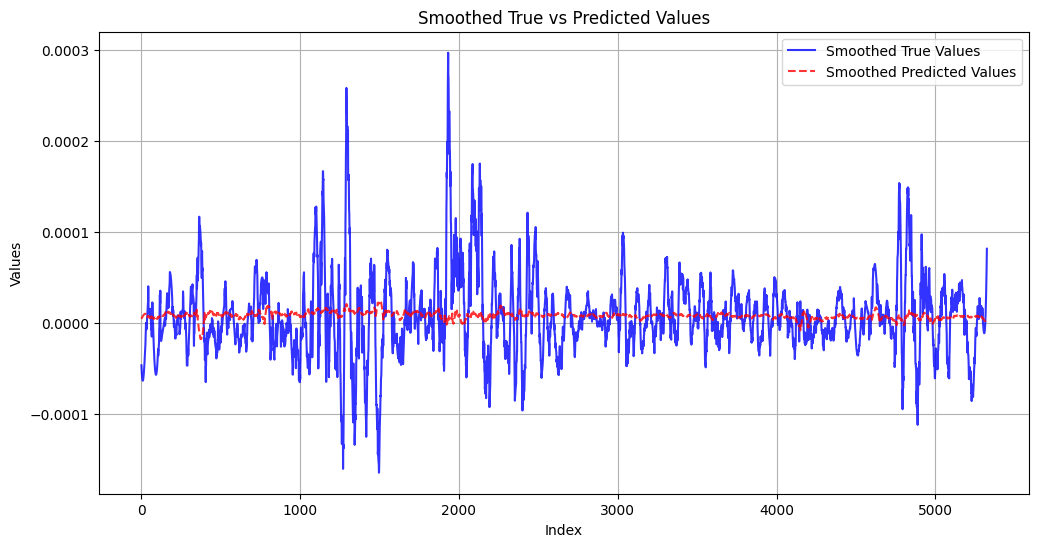

In [21]:
catboost_model = CatBoostRegressor(**study.best_params, random_state=42)

test_pool = Pool(data=X_test, label=y_test,  cat_features=cat_features)
catboost_model.fit(test_pool, cat_features=None, verbose=False, plot=True)
y_pred = catboost_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MSE on test: {mse:.4f} \nMAPE on test: {mape:.4f}")
plot_predictions(y_test, y_pred)

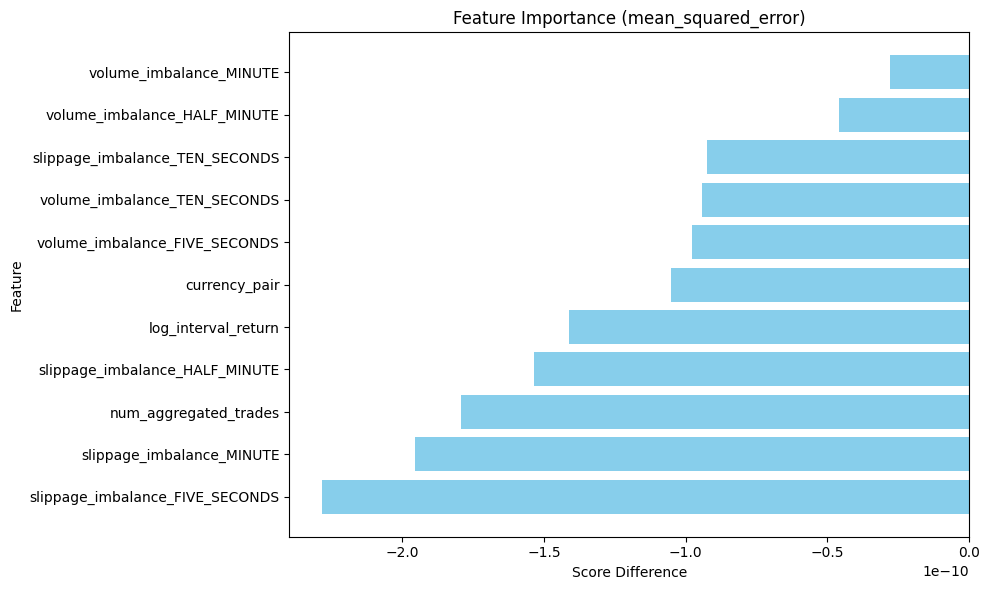

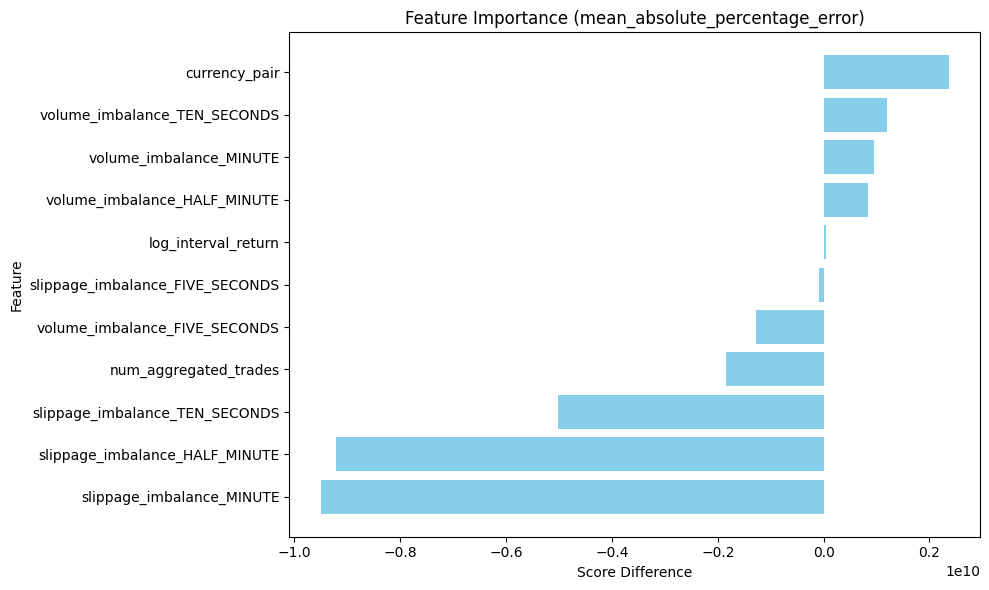

In [22]:
results = permutation_feature_importance(model=catboost_model, X_test=X_test, y_test=y_test, metrics=[mean_squared_error, mean_absolute_percentage_error])
plot_feature_premutation_importance(results)

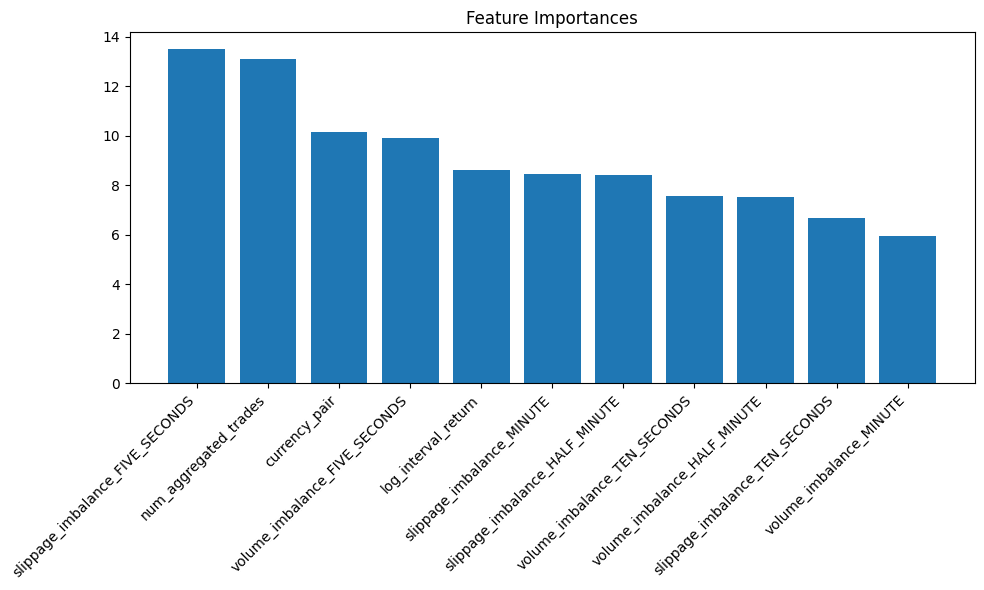

In [23]:
plot_feature_importance(catboost_model, X_train.columns)